# Project 1 - d20 Size to Fairness Study

## The Question
"Does the size variation among the faces on a d20 affect its probability?"

The twenty sided die is a common symbol in the tabletop roleplaying game community. It's the main die used in Dungeons & Dragons for determining the outcome of many events. Because the fate of their characters depend on a roll of the die, many players are concerned about fairness.

There are many superstitions and assumptions around what makes a die roll fairly. One assumption, as proposed by Col. Louis Zocchi, the creator of Gamescience dice, is that during the manufacturing process for dice, the tumbling step introduces small variations in the shape of the die. The tumbling process of dice manufacturing typically serves two purposes, to remove excess ink and smooth out the edges between vertices on the dice. Col. Zocchi claims that his dice, which do not go through this process, are more fair because they are more evenly sized than other manufacturers.

## The Study
In this study, I intend to determine if small variations in a die's shape does affect the probability of certain numbers showing up and quantify the relationship between the two. To do this, I'm going to be measuring samples from multiple manufacturers and rolling them.

## Methodology

### Measuring the Dice
To measure how a d20 can vary in shape, I took a set of calipers and measured each pair of faces on the dice. To ensure standardized measurement for all the dice, the faces were measured so that the calipers crossed vertically through the numbers printed on the faces measured.

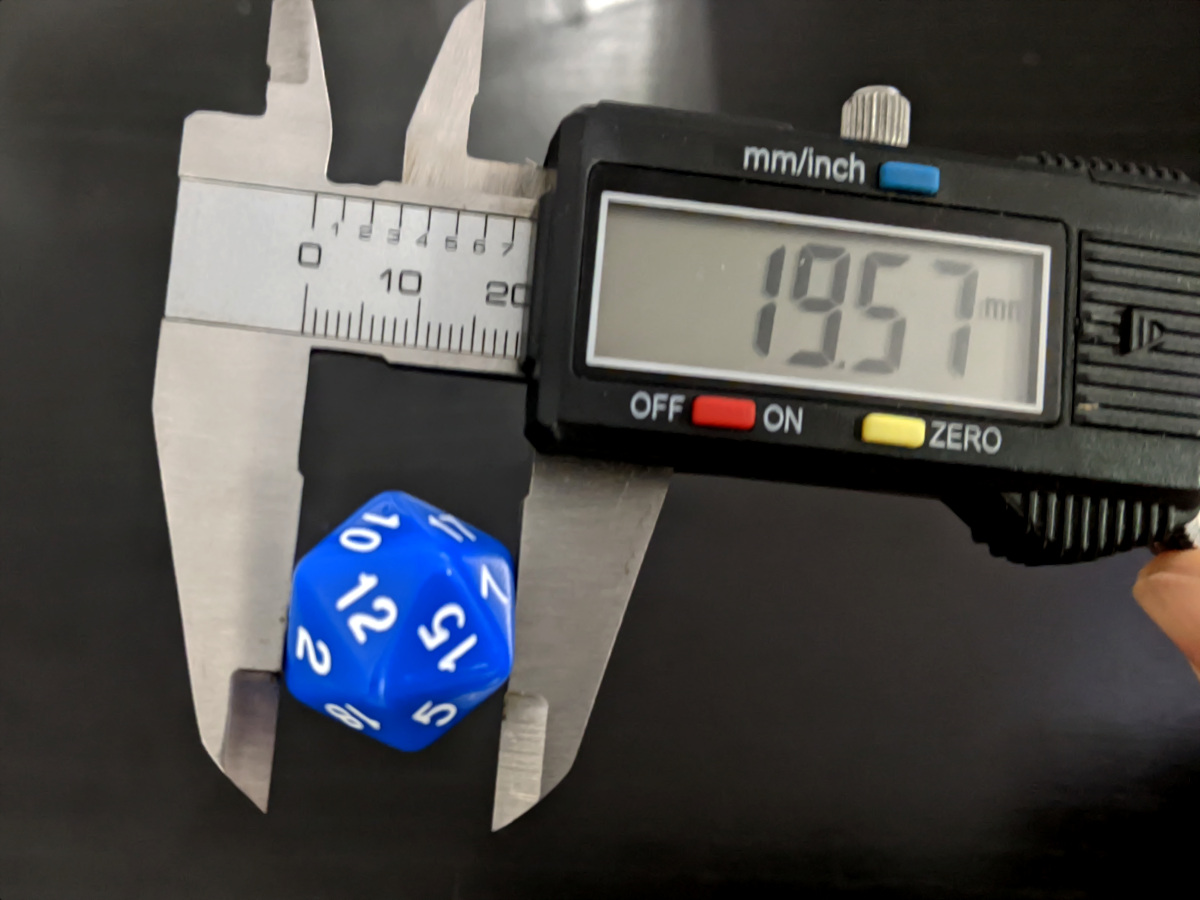

In this example the pair of faces on this die, labeled as 1:20 would be recorded at 19.57mm. This process was repeated for each pair of faces on the die, 10 in total.

### Rolling the Dice
Each die was rolled through an acrylic dice tower with 4 ramps in total and the front stop plate removed.

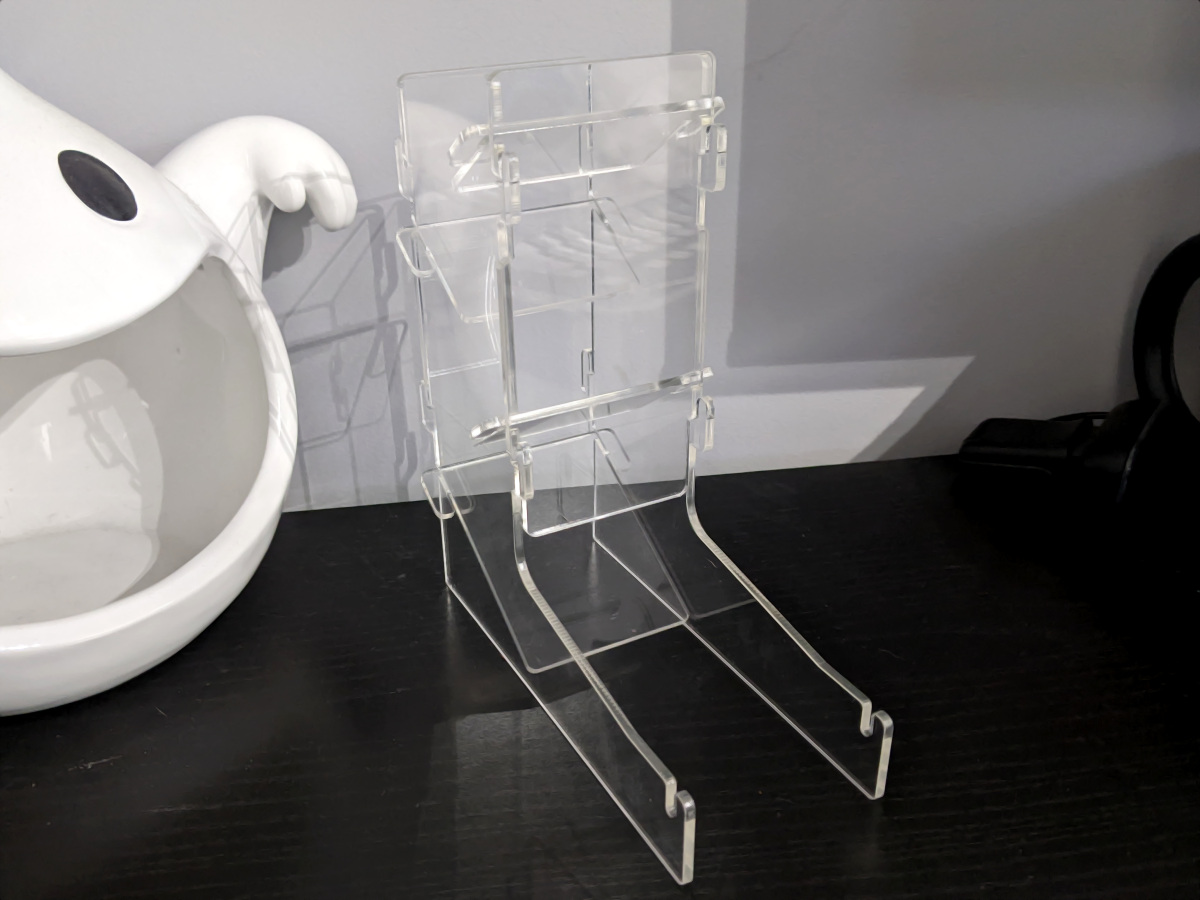

To ensure a random starting position at the top of the tower, when picked up for a roll the die was shaken in my hand a couple times before being dropped in. After going through the tower, the dice were allowed to roll along the surface until naturally stopping on a result and recorded.

## Results Summary

### Is there a variation in the shape of dice?
Yes. After measuring 51 dice in total, there is a measureable variation amongst the face pairs for each die.

### Does that variation affect roll frequency?
Yes. After comparing the variation in size of each face pair to their roll frequencies, there is a measureable inverse relationship between the size variation and roll frequency. Such that the smaller the diameter is for a pair of faces on a die, the higher chance exists of that pair being rolled.

### Can you determine fairness with measurements alone?
Maybe. While there is a strong correlation between the round score of a given die and the eventual chi square statistic of that die, due to the sensitivity of the chi square test and the standard error of the relationship, there is potential for prediction errors around the boundary between fair and not fair from the chi square test.

### Is there a noticeable difference between manufacturers?
Yes. When comparing samples from different manufacturers, there is a distinct difference in the round scores of the dice between them. However, it would be irresponsible to state from this small sample set that one manufacturer produces unfair dice. There are manufacturing differences between different product lines within a single manufacturer, and to determine fairness from those product lines more dice will need to be measured.

## Study Limitations

#### Results in Face Pairs Only
Due to how the dice were measured, the results for this experiment can only be presented in pairs of opposite faces on the die. I was unable to determine a way to accurately measure the radius from each face from a central point on the die. Therefore, for example, it was impossible to determine if the radius of the "20" face would be higher than the radius of the "1" face. As such, the pair of faces was treated as a single category.

#### Results only for polymer dice
While there are many dice made from different materials, for this experiment I focused on dice that are made of commonly available plastics or resins. The results might not hold true for dice made from other materials.

#### Results only for hard rolling surface
All dice were rolled on the same hard surface to eliminate variation from surface material. The results might not hold true for other surfaces, such as leather dice trays, plastic folding tables, glass tables, etc.

#### Results only for similarly sized dice
All the dice in this experiment were of a similar size, around 20 mm in diameter. The results might not hold true for dice of significantly larger or smaller sizes, such as "Chunk" or "Mini" dice commonly sold.

# Initial Data Prep

#### Load required Python libraries for analysis.

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib as mpl

from sklearn.linear_model import LinearRegression
from sklearn import metrics 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.optimize import curve_fit
from scipy import stats
from lmfit import Model

np.random.seed(20)

%matplotlib inline

#### Load raw experiment data.

In [2]:
dice_df = pd.read_csv('data/dice.csv')
face_pairs_df = pd.read_csv('data/face_pairs.csv')
faces_df = pd.read_csv('data/faces.csv')
rolls_df = pd.read_csv('data/rolls.csv')

#### Get count of results for each die & face.

In [3]:
rolls_cnt = rolls_df.groupby(['dice_id', 'result']).agg(count=('result', 'count'))
rolls_cnt = pd.DataFrame(rolls_cnt).reset_index()
rolls_cnt.head()

,dice_id,result,count
0,1,1,5
1,1,2,5
2,1,3,15
3,1,4,16
4,1,5,8


#### Get count of results for each die by face pair.

In [4]:
pair_cnt = pd.merge(faces_df, 
                    rolls_cnt, 
                    left_on=['dice_id', 'face'], 
                    right_on=['dice_id', 'result'])
pair_cnt = pair_cnt.groupby(['dice_id', 'face_pair'])['count'].sum()
pair_cnt = pd.DataFrame(pair_cnt).reset_index()
pair_cnt.head()

,dice_id,face_pair,count
0,1,10:11,17
1,1,1:20,9
2,1,2:19,15
3,1,3:18,24
4,1,4:17,34


#### Join results with dice measurements.

In [5]:
results_df = pd.merge(face_pairs_df, pair_cnt, on=['dice_id', 'face_pair'])
results_df.head()

,dice_id,face_pair,diameter,count
0,1,1:20,20.11,9
1,1,2:19,19.92,15
2,1,3:18,19.59,24
3,1,4:17,19.54,34
4,1,5:16,19.62,23


# Analysis 1 - Size Deviation to Roll Frequency

## Analysis Overview
The purpose of this analysis is to determine if there is a relationship between the variation in size of a d20 and the eventual frequencies of those faces being rolled.

## Metrics
For this analysis we'll be using two key metrics: Roll Frequency and Size Variation

### Roll Frequency

The first metric used in the analysis is roll frequency. This is the proportion of the total rolls made with the die in which the result was one of the two faces in the given pair.

For example:
If 1 & 20 were rolled 4 & 5 times respectively out of 200 rolls, the roll frequency would be 0.045, or 4.5%.

$\Large \frac{(4 + 5)}{200} = 0.045 $

#### Get total rolls for each die

In [6]:
total_rolls = results_df.groupby('dice_id').agg(total_rolls=('count', 'sum'))
results_df = pd.merge(results_df, total_rolls, on='dice_id')
results_df.head()

,dice_id,face_pair,diameter,count,total_rolls
0,1,1:20,20.11,9,200
1,1,2:19,19.92,15,200
2,1,3:18,19.59,24,200
3,1,4:17,19.54,34,200
4,1,5:16,19.62,23,200


#### Calculate roll frequency

In [7]:
results_df['roll_freq'] = results_df['count'] / results_df['total_rolls']
results_df.head()

,dice_id,face_pair,diameter,count,total_rolls,roll_freq
0,1,1:20,20.11,9,200,0.045
1,1,2:19,19.92,15,200,0.075
2,1,3:18,19.59,24,200,0.120
3,1,4:17,19.54,34,200,0.170
4,1,5:16,19.62,23,200,0.115


### Size Variation
The second metric used is size variation. This is the percentage difference of the diameter of the given face pair is from the mean diameter of the total die. This number is calculated as `(diameter - mean_dia) / mean_dia`. This is to normalize the variation amongst different sized dice.

For example
If the diameter for the 1:20 pair is 20.11 and the mean diameter of all the faces of the die is 19.769, the size variation for that face pair would be 0.0172, or 1.72% larger than the mean diameter.

$\Large \frac{20.11}{19.769} = 0.0172 $

#### Get mean diameter for each die

In [8]:
mean_dia = results_df.groupby('dice_id').agg(mean_dia=('diameter', 'mean'))
results_df = pd.merge(results_df, mean_dia, on='dice_id')
results_df.head()

,dice_id,face_pair,diameter,count,total_rolls,roll_freq,mean_dia
0,1,1:20,20.11,9,200,0.045,19.769
1,1,2:19,19.92,15,200,0.075,19.769
2,1,3:18,19.59,24,200,0.120,19.769
3,1,4:17,19.54,34,200,0.170,19.769
4,1,5:16,19.62,23,200,0.115,19.769


#### Get Size Variation

In [9]:
results_df['size_var'] = (results_df['diameter'] - results_df['mean_dia']) / results_df['mean_dia']
results_df.head()

,dice_id,face_pair,diameter,count,total_rolls,roll_freq,mean_dia,size_var
0,1,1:20,20.11,9,200,0.045,19.769,0.017249
1,1,2:19,19.92,15,200,0.075,19.769,0.007638
2,1,3:18,19.59,24,200,0.120,19.769,-0.009055
3,1,4:17,19.54,34,200,0.170,19.769,-0.011584
4,1,5:16,19.62,23,200,0.115,19.769,-0.007537


## Results Visualization

Let's visualize the relationship between size variation and roll frequency for a potential relationship.

We'll set our x axis to size variation, centered on 0 as our baseline of no variation on the die. Our y axis will be roll frequency, centered on 10%. On a completely fair d20, each of the 10 faces would be rolled 10% of the time.

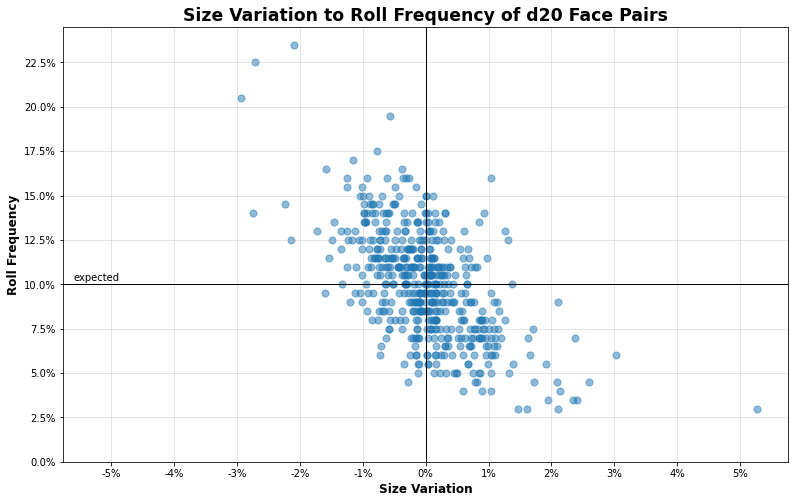

In [10]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.scatter(results_df['size_var'], 
           results_df['roll_freq'],
           alpha=0.5,
           s=50
          )

# Chart Formatting
ax.set_title('Size Variation to Roll Frequency of d20 Face Pairs', fontweight='bold', fontsize='xx-large')
ax.set_xlabel('Size Variation', fontweight='bold', fontsize='large')
ax.set_ylabel('Roll Frequency', fontweight='bold', fontsize='large')

# Axis Formatting
ax.grid(alpha=0.4)

ax.set_xticks([x/100 for x in range(-5, 6)])
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.0%}'))
ax.axvline(0, c='black', lw=1)
xlim = max(abs(results_df['size_var'])) + 0.005
ax.set_xlim(-xlim, xlim)

ax.set_yticks([x/40 for x in range(10)])
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.1%}'))
ax.axhline(.10, c='black', lw=1)
ax.text(-0.056, 0.102, 'expected')
ylim = max(abs(results_df['roll_freq'])) + 0.01
ax.set_ylim(0, ylim)

fig.savefig('images/Project 1 - fig2a.png', dpi=300, bbox_inches = 'tight')

Looking at the data, there appears to be some sort of inverse relationship between size variation and the roll frequency. 

If there was no relationhip between the two, we would expect to see all of our points clustered around the 10% expected roll frequency line, regardless of what the size variation score is. But in this case, we can see that as our size variation goes up, the data points for roll frequency tend to go down, and vice versa.

## Linear Regression

A casual glance at the data suggest that there could be  linear relationship between size variation and roll frequency. Let's run the data points through a linear regression, with size variation predicting roll frequency, and see what our results look like.

#### Fitting the model

In [11]:
lr_model = smf.ols(formula='roll_freq ~ size_var', data=results_df)
lr_res = lr_model.fit()
lr_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              roll_freq   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     286.9
Date:                Fri, 25 Mar 2022   Prob (F-statistic):           2.36e-51
Time:                        10:06:44   Log-Likelihood:                 1167.6
No. Observations:                 510   AIC:                            -2331.
Df Residuals:                     508   BIC:                            -2323.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1000      0.001     91.923      0.000       0.098       0.102
size_var      -2.3217      0.137    -16.939      0.000      -2.591      -2.052
==============================================================================
Omnibus:                       10.189   Durbin-Watson:                   2.249
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.212
Skew:                           0.335   Prob(JB):                      0.00606
Kurtosis:                       3.178   Cond. No.                         126.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Linear Model Stats

Let's take a quick look at some of the stats we got out of our linear regression.

First let's look at the p-values. These will tell us the significance of our results. Any number below 0.05 in our case means significance, and all of our p-values are well below that. So this is good, we have significant data!

Next let's look at our R squared. This will tell us the predictability of our model. It's at 0.361, which isn't bad. This means we have correlation coefficient around 0.6, which is a moderate to strong correlation. However, there is an issue with using this metric as a measure of how well the model tracks behavior, but I will address that in a moment when we discuss our residuals.

### Plotting the Regression Line

Let's plot the line from our regression on our data points to visualize the predicted relationship.

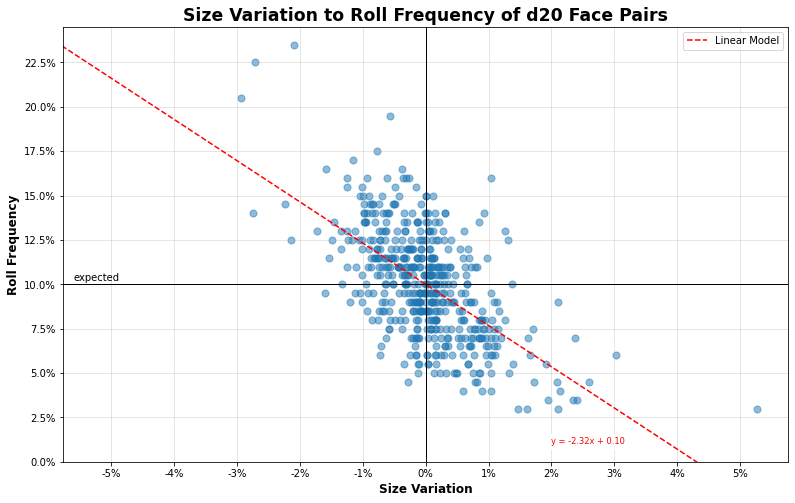

In [12]:
line_x = pd.DataFrame({'size_var': np.linspace(-0.06, 0.06, 10)})

lr_line = ax.plot(line_x,
                  lr_res.predict(line_x), 
                  c='red',
                  linestyle='dashed',
                  label='Linear Model')

b, m = lr_res.params
formula = 'y = {m:.2f}x + {b:.2f}'.format(m=m, b=b)
ax.text(0.02, 0.01, formula, c='red', backgroundcolor='white', fontsize='small')

ax.legend()

fig.savefig('images/Project 1 - fig2b.png')

fig

The line appears to fit the data well, but putting the line with the data points shows a problem with assuming the relationship is linear.

On the lower right side of the graph is a data point where the size variation of the face pair is over 5%. With our linear model, the predicted roll frequency would be in the negative. That's not possible. A result can't have a negative chance of being rolled.

We need to think about the problem differently, because this relationship doesn't make sense as a linear one. We know that our roll frequency has to be within 0 - 100%. Because of this behavior, let's look at a different kind of line to act as our predictor, the logistic curve.

## Logistic Curve

Let's take a quick look at how a logistic curve, also called an S-curve or sigmoid curve, differs.

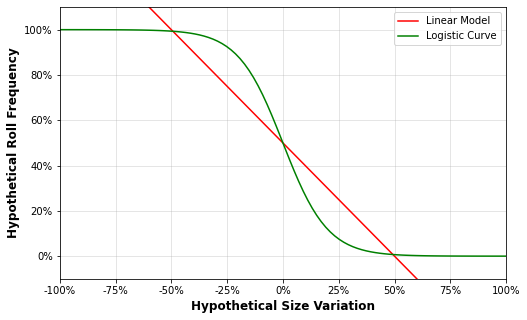

In [13]:
line_x = pd.DataFrame({'size_var': np.linspace(-1, 1, 100)})

line_y = -line_x + 0.5
logi_y = 1 / (1 + np.exp(10 * line_x))

fig2, ax2 = plt.subplots(figsize=(8, 5))

ax2.plot(line_x, line_y, c='red', label='Linear Model')
ax2.plot(line_x, logi_y, c='green', label='Logistic Curve')

# Chart Formatting
ax2.set_xlabel('Hypothetical Size Variation', fontweight='bold', fontsize='large')
ax2.set_ylabel('Hypothetical Roll Frequency', fontweight='bold', fontsize='large')

# Axis Formatting
ax2.grid(alpha=0.4)

ax2.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.0%}'))
ax2.set_xlim(-1, 1)

ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.0%}'))
ax2.set_ylim(-0.1, 1.1)

ax2.legend()

fig2.savefig('images/Project 1 - fig3.png')

The logistic curve we'll be working with will never go above 100% or below 0%. As the size variation moves up or down, it will get closer, but never actually cross those lines. Because our roll frequency can never go above 100% or below 0%, due to how it's calculated, it will fit the behavior better.

Let's fit a logistic curve to our data and look at the results.

#### Fitting the model

In [14]:
def sigmoid(x, x0, k):
    # L (max) set to 1, as 100% is theorhetical max.
    # k positive to reverse standard Logistic Function.
    y = 1 / (1 + np.exp(k * (x - x0)))
    return (y)

sig_model = Model(sigmoid)
sig_result = sig_model.fit(results_df['roll_freq'], 
                       x=results_df['size_var'], 
                       x0=np.median(results_df['size_var']), 
                       k=1)

x0, k = [param.value for param in sig_result.params.values()]

sig_result

### Logistic Model Stats

I want to focus on the AIC (Akaike info crit.) and BIC (Baysian info crit.). We can compare these metrics from our logistic curve to the same metrics from the linear model. When we do so, we can see that both are lower than what we get from the linear model. This means that our logistic model is a better fit for explaining the behavior we are seeing than the linear model is.

Let's plot the line we get from the logistic curve onto our data points.

### Plotting the Regression Line

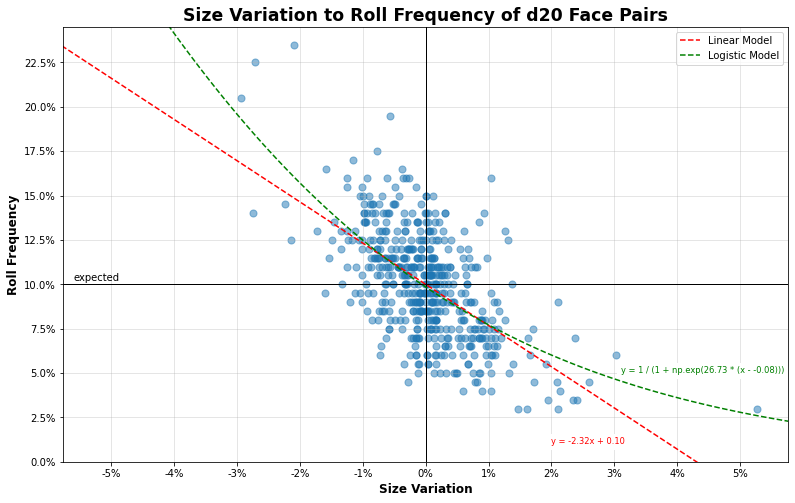

In [15]:
line_x = np.linspace(-0.06, 0.06, 100)

pr_line = ax.plot(line_x,
                  sigmoid(line_x, x0, k), 
                  c='green',
                  linestyle='dashed',
                  label='Logistic Model')

formula = 'y = 1 / (1 + np.exp({k:.2f} * (x - {x0:.2f})))'.format(x0=x0, k=k)
ax.text(0.031, 0.05, formula, c='green', backgroundcolor='white', fontsize='small')

ax.legend()

fig.savefig('images/Project 1 - fig2c.png')

fig

Now we can see that the data point with a little more than 5% size variation is closer to the line and no longer being predicted into the negative.

## Analysis Results

In the above analysis, we can see that there appears to be a significant relationship between the size variation of a face pair on a d20 and the frequency of rolls from that face pair. This relationship can be defined as:

$\Large y = \frac{1}{1 + e^{ 26.73 \cdot (x + 0.08)}} $

Where `x` is Size Variation and `y` is Roll Frequency.

# Analysis 2 - Standard Error Explanation

## Analysis Overview
I want to take a closer look at the standard error of our predictions. This is a measurement of how far off our predictions are from the actual results we got from rolling the dice. It's my suspiscion that most of the variation we are seeing can be explained by the random nature of dice rolls, rather than errors in our predictability.

## Calculating Standard Error

We'll start by getting the residuals from our predictor. This is the difference between the predicted values and actual values for roll frequency.

#### Visualizing Residuals

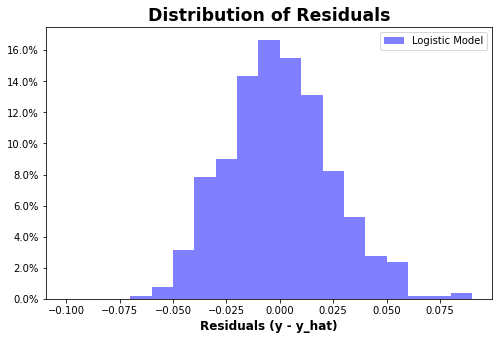

In [16]:
y_hat = sigmoid(results_df['size_var'], x0, k)
residuals = results_df['roll_freq'] - y_hat

fig3, ax3 = plt.subplots(figsize=(8, 5))

ax3.hist(residuals, 
         bins=np.arange(-0.1, 0.1, 0.01), 
         density=True, 
         color='blue',
         alpha=0.5,
         label='Logistic Model')

ax3.set_title('Distribution of Residuals', fontweight='bold', fontsize='xx-large')
ax3.set_xlabel('Residuals (y - y_hat)', fontweight='bold', fontsize='large')
ax3.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=100))

ax3.legend()

fig3.savefig('images/Project 1 - fig4a.png')

We see that our residuals appear to be in a fairly normal distribution.

#### Get Standard Error

In [17]:
print('Standard Error: {0}'.format(np.sqrt(sig_result.redchi)))

Standard Error: 0.024405747785889827


Our standard error with this predictor is 0.0244. This gives our 95% confidence intervals for the predictor to be +- 4.78%. 

And error range of close to 5% seems like a lot for our predictor, but in dealing with random outcomes, we'll compare this result to another distribution.

## "Perfect" Die Simulation

We are going to run a simulation of rolling multiple fair d20's 200 times each.

To do this we are going to use numpy's random.randint function, which pulls from a discrete uniform distribution. The number of dice "rolled" for this simulation is equal to the number of dice rolled in the actual experiment.

From this simulation we will see how our roll frequencies from fair dice compare to the expected frequency.

In [18]:
def get_face_pair(row):
    if row['face'] < row['opposite']:
        lower = row['face']
        higher = row['opposite']
    else:
        lower = row['opposite']
        higher = row['face']
        
    return str(int(lower)) + ':' + str(int(higher))

dice_count = len(rolls_df['dice_id'].unique())
roll_count = 200

d = {'dice_id': sorted([x + 1 for x in range(dice_count)] * roll_count),
     'result': np.random.randint(1, 21, roll_count * dice_count)}
perfect_df = pd.DataFrame(data=d)

perfect_df = perfect_df.groupby(['dice_id', 'result']).size().reset_index()
perfect_df.columns = ['dice_id', 'face', 'count']
perfect_df['opposite'] = 21 - perfect_df['face']

perfect_df['face_pair'] = perfect_df.apply(get_face_pair, axis=1)

perfect_df = perfect_df.groupby(['dice_id', 'face_pair']).agg(count=('count', 'sum')).reset_index()

perfect_df['roll_freq'] = perfect_df['count'] / roll_count
perfect_df['expected'] = 0.1

perfect_df['freq_diff'] = perfect_df['roll_freq'] - perfect_df['expected']

perfect_df.head()

,dice_id,face_pair,count,roll_freq,expected,freq_diff
0,1,10:11,31,0.155,0.1,0.055
1,1,1:20,15,0.075,0.1,-0.025
2,1,2:19,23,0.115,0.1,0.015
3,1,3:18,15,0.075,0.1,-0.025
4,1,4:17,16,0.080,0.1,-0.020


### Comparison to Logistic Model Standard Error

With the difference in our actual frequencies from the expected, we can compare this to our logistic model's residuals

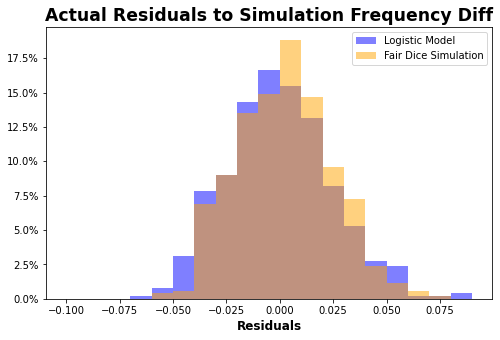

In [19]:
fig4, ax4 = plt.subplots(figsize=(8, 5))

ax4.hist(residuals, 
         bins=np.arange(-0.1, 0.1, 0.01), 
         density=True, 
         color='blue',
         alpha=0.5,
         label='Logistic Model')

ax4.hist(perfect_df['freq_diff'], 
         bins=np.arange(-0.1, 0.1, 0.01), 
         density=True, 
         color='orange',
         alpha=0.5,
         label='Fair Dice Simulation')

ax4.set_title('Actual Residuals to Simulation Frequency Diff', fontweight='bold', fontsize='xx-large')
ax4.set_xlabel('Residuals', fontweight='bold', fontsize='large')
ax4.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=100))

ax4.legend()

fig4.savefig('images/Project 1 - fig4b.png')

In [20]:
std_err = np.sqrt( sum(perfect_df['freq_diff']**2) / (len(perfect_df['freq_diff']) - 2) )

print('Standard Error: {0}'.format(std_err))

Standard Error: 0.0222282362815626


Visually, the residuals from our predictor and the natural variation from random fair rolls appear really close to one another. And the standard error from our predictor is close to the standard deviation from our fair simulation: 0.0244 compared to 0.0222.

To determine how similar our residuals are to the natural variation, we'll run both sets through two tests: an F-Test and a Levene's Test. Both of these tests compare variances between two data sets to determine if it's possible that they could come from the same distribution. Meaning in this case that our residuals can be explained by the natural variation of dice rolls.

For both of these tests we'll set an alpha of 0.05. If the p-value is less than this threshold for each test, then the two distributions are different enough from one another to totally explain the residuals.

##### F-Test

In [21]:
pred_var = np.var(residuals, ddof=1)
perfect_var = np.var(perfect_df['freq_diff'], ddof=1)
F = pred_var / perfect_var

p_value = stats.f.sf(F, len(residuals)-1, len(perfect_df['freq_diff'])-1)

F, p_value

(1.205517691194013, 0.017608025867714414)

##### Levene's Test

In [22]:
stats.levene(residuals, perfect_df['freq_diff'])

LeveneResult(statistic=2.8506945119946607, pvalue=0.09164074331968809)

In this case we got two conflicting results.

The F-Test suggests that the variances are different enough and that we cannot completely explain the residualss with the natural variation of randomness. However the Levene's Test gives the opposite result, that the residuals could have entirely come from the natural variation in roll frequencys from random rolls.

With these conflicting results, it's suggested that some, but not all of the variation present in the results are from the random nature of the experiment.

## Analysis Results

The residual standard error for the model is 0.244, some, but not all, of which can be contributed to the natural variation in roll frequency from 200 rolls.

# Analysis 3 - Predictive Dice Fairness from Round Score

## Analysis Overview
Since there is a relationship between the variation in diameters of the face pairs on a die and the probabilities of those rolls, is it possible to predict if a die can be defined as fair from just measuring the die?

To do this analysis, we're going to be leveraging the Chi Square Goodness of Fit Test. This test will tell us if the results we get from a die could have come from a fair die or not. Using this, we can get a definition of if a die is fair or not.

## Metrics
For this analysis, we'll be using two metrics: the Round Score and the Chi Square Statistic.

### Chi Square Statistic
The Chi Square Statistic we'll be using is the sum of the squared difference between the observed results and expected results, divided by the expected results. Essentially, it's a measure of how far off the number of rolls we actually saw for each face pair compares to the number we expected to get.

For example:

For a die, out of 200 rolls we got the following results:

| Face Pair | Count Rolled | Expected |
| --- | --- | --- |
| 1:20 | 9 | 20 |
| 2:19 | 15 | 20 |
| 3:18 | 24 | 20 |
| 4:17 | 34 | 20 |
| 5:16 | 23 | 20 |
| 6:15 | 31 | 20 |
| 7:14 | 12 | 20 |
| 8:13 | 13 | 20 |
| 9:12 | 22 | 20 |
| 10:11 | 17 | 20 |

We can get the difference between the count rolled and expected count:

| Face Pair | Count Rolled | Expected | Difference |
| --- | --- | --- | --- |
| 1:20 | 9 | 20 | -11 |
| 2:19 | 15 | 20 | -5 |
| 3:18 | 24 | 20 | 4 |
| 4:17 | 34 | 20 | 14 |
| 5:16 | 23 | 20 | 3 |
| 6:15 | 31 | 20 | 11 |
| 7:14 | 12 | 20 | -8 |
| 8:13 | 13 | 20 | -7 |
| 9:12 | 22 | 20 | 2 |
| 10:11 | 17 | 20 | -3 |

Finally, we square those results and divide them by the expected count. When we add all those numbers up we get a final statistic that we can use to give us a sense of how far the total results are from what we expect.

| Face Pair | Count Rolled | Expected | Difference | Chi Sq |
| --- | --- | --- | --- | --- |
| 1:20 | 9 | 20 | -11 | 6.05 |
| 2:19 | 15 | 20 | -5 | 1.25 |
| 3:18 | 24 | 20 | 4 | 0.80 |
| 4:17 | 34 | 20 | 14 | 9.80 |
| 5:16 | 23 | 20 | 3 | 0.45 |
| 6:15 | 31 | 20 | 11 | 6.05 |
| 7:14 | 12 | 20 | -8 | 3.20 |
| 8:13 | 13 | 20 | -7 | 2.45 |
| 9:12 | 22 | 20 | 2 | 0.20 |
| 10:11 | 17 | 20 | -3 | 0.45 |
| --- | --- | --- | **Total** | **30.7** |

In this case, our Chi Square Statistic is 30.7. We'll be able to put that into more context later.

#### Get expected roll count for each face pair.

Calculated as `total_rolls // 10` as each d20 has 10 face pairs.

In [23]:
results_df['expected'] = results_df['total_rolls'] // 10
results_df.head()

,dice_id,face_pair,diameter,count,total_rolls,roll_freq,mean_dia,size_var,expected
0,1,1:20,20.11,9,200,0.045,19.769,0.017249,20
1,1,2:19,19.92,15,200,0.075,19.769,0.007638,20
2,1,3:18,19.59,24,200,0.120,19.769,-0.009055,20
3,1,4:17,19.54,34,200,0.170,19.769,-0.011584,20
4,1,5:16,19.62,23,200,0.115,19.769,-0.007537,20


#### Calculate Chi Square K

Calculated as `(count - expected)^2 / expected`

In [24]:
results_df['chisq_k'] = ((results_df['count'] - results_df['expected'])**2) / results_df['expected']
results_df.head()

,dice_id,face_pair,diameter,count,total_rolls,roll_freq,mean_dia,size_var,expected,chisq_k
0,1,1:20,20.11,9,200,0.045,19.769,0.017249,20,6.05
1,1,2:19,19.92,15,200,0.075,19.769,0.007638,20,1.25
2,1,3:18,19.59,24,200,0.120,19.769,-0.009055,20,0.80
3,1,4:17,19.54,34,200,0.170,19.769,-0.011584,20,9.80
4,1,5:16,19.62,23,200,0.115,19.769,-0.007537,20,0.45


#### Get Chi Square Statistic by die

In [25]:
chi_sq_stats = results_df.groupby('dice_id').agg(chisq_stat=('chisq_k', 'sum'))
dice_results = pd.merge(dice_df, chi_sq_stats, on='dice_id')
dice_results.head()

,dice_id,brand,line,style,weight_g,chisq_stat
0,1,Chessex (Factory 2nd),Opaque,Opaque Purple with White,6.2,30.7
1,2,Chessex (Factory 2nd),Opaque,Opaque Yellow with Black,5.9,43.2
2,3,Chessex (Factory 2nd),Speckled,Speckled Blue/Green with White,6.5,16.9
3,4,Chessex (Factory 2nd),Speckled,Speckled Light Blue with Black,6.5,28.8
4,5,Chessex (Factory 2nd),Translucent,Translucent Blue with White,4.9,37.0


### Round Score
The Round Score is a metric designed for this study to determine how evenly shaped a d20 is. It's defined at the normed standard deviation of the measured diameters times 1000.

The standard deviation of the diameters measured on each die is divided by the mean diameter to normalize results over differences in the total size of the die.

#### Calculate Round Score for each die

In [26]:
round_scores = results_df.groupby('dice_id').agg(std_dev=('diameter', 'std'),
                                                 mean_dia=('mean_dia', 'first'))
round_scores.reset_index(inplace=True)
round_scores['round_score'] = (round_scores['std_dev'] / round_scores['mean_dia']) * 1000
dice_results = pd.merge(dice_results, round_scores, on='dice_id')
dice_results.head()

,dice_id,brand,line,style,weight_g,chisq_stat,std_dev,mean_dia,round_score
0,1,Chessex (Factory 2nd),Opaque,Opaque Purple with White,6.2,30.7,0.196551,19.769,9.942375
1,2,Chessex (Factory 2nd),Opaque,Opaque Yellow with Black,5.9,43.2,0.208489,19.773,10.544140
2,3,Chessex (Factory 2nd),Speckled,Speckled Blue/Green with White,6.5,16.9,0.183799,19.816,9.275303
3,4,Chessex (Factory 2nd),Speckled,Speckled Light Blue with Black,6.5,28.8,0.216500,19.925,10.865743
4,5,Chessex (Factory 2nd),Translucent,Translucent Blue with White,4.9,37.0,0.273051,18.853,14.483142


## Results Visualization
Let's look at a graph of round scores on our x-axis to chi square statistics on our y-axis.

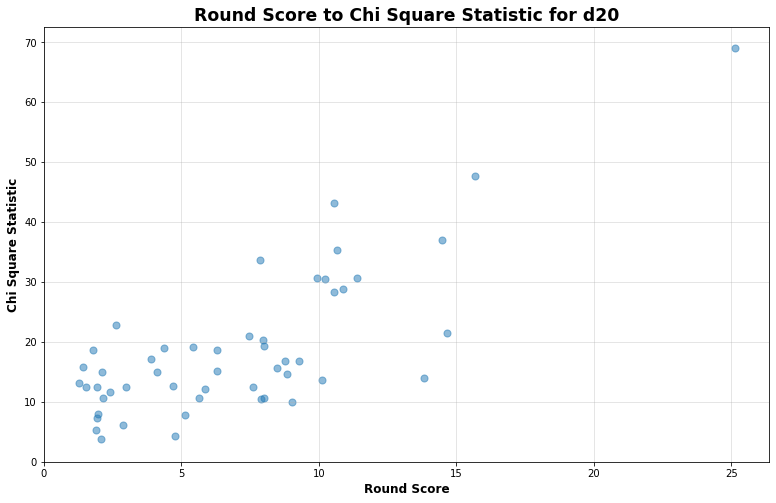

In [27]:
fig5, ax5 = plt.subplots(figsize=(13, 8))
ax5.scatter(dice_results['round_score'], 
            dice_results['chisq_stat'],
            alpha=0.5,
            s=50)

# Chart Formatting
ax5.set_title('Round Score to Chi Square Statistic for d20', fontweight='bold', fontsize='xx-large')
ax5.set_xlabel('Round Score', fontweight='bold', fontsize='large')
ax5.set_ylabel('Chi Square Statistic', fontweight='bold', fontsize='large')

# Axis Formatting
ax5.grid(alpha=0.4)

ax5.set_xticks(np.arange(0, 30, 5))
xlim = max(dice_results['round_score']) * 1.05
ax5.set_xlim(0, xlim)

ax5.set_yticks(np.arange(0, 80, 10))
ylim = max(dice_results['chisq_stat']) * 1.05
ax5.set_ylim(0, ylim)

fig5.savefig('images/Project 1 - fig5a.png')

The graph suggests that there is a relationship between round scores and the chi square statistics. The trend appears linear, so we will run the data through a linear regression

## Linear Regression

In [28]:
lr_model = smf.ols(formula='chisq_stat ~ round_score', data=dice_results)
lr_res = lr_model.fit()
lr_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             chisq_stat   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     71.78
Date:                Fri, 25 Mar 2022   Prob (F-statistic):           3.65e-11
Time:                        10:06:46   Log-Likelihood:                -176.23
No. Observations:                  51   AIC:                             356.5
Df Residuals:                      49   BIC:                             360.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.9470      1.969      2.512      0.015       0.989       8.904
round_score     1.9943      0.235      8.472      0.000       1.521       2.467
==============================================================================
Omnibus:                        0.077   Durbin-Watson:                   1.809
Prob(Omnibus):                  0.962   Jarque-Bera (JB):                0.274
Skew:                          -0.029   Prob(JB):                        0.872
Kurtosis:                       2.645   Cond. No.                         15.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Linear Model Stats
Looking at the p-values from our linear model, we can see that they are below the 0.05 threshold for significance. So we can determine that we do have some statistically significant results.

Our R-squared is 0.594, which gives us a correlation coefficient of 77. This implies a strong correlation between the round scores and the chi square statistic. So it seems that we can use the round score as a measure of how likely the results are to come from a fair die.

### Plotting the Regression Line

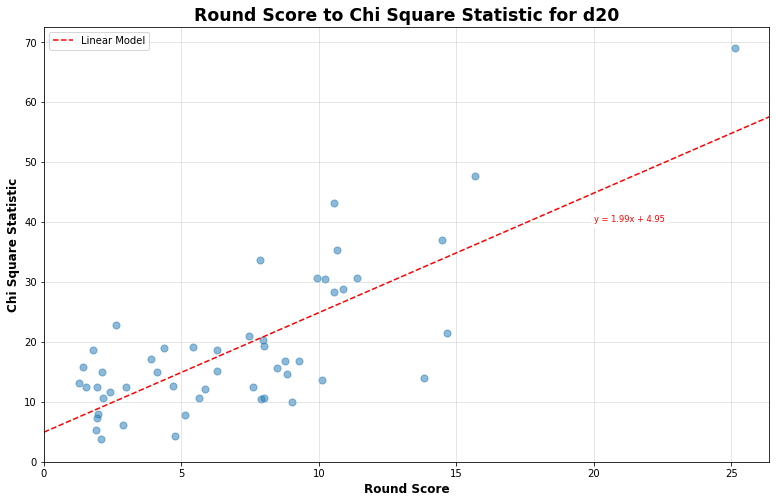

In [29]:
line_x = pd.DataFrame({'round_score': np.linspace(0, 30, 10)})

lr_line = ax5.plot(line_x,
                   lr_res.predict(line_x), 
                   c='red',
                   linestyle='dashed',
                   label='Linear Model')

b, m = lr_res.params
formula = 'y = {m:.2f}x + {b:.2f}'.format(m=m, b=b)
ax5.text(20, 40, formula, c='red', backgroundcolor='white', fontsize='small')

ax5.legend()

fig5.savefig('images/Project 1 - fig5b.png')

fig5

## Understanding Chi Square Statistic
Let's take a closer look at the chi square statistic, and how we can use it to determine if the rolls we got came from a fair die or not.

To determine if the results could have come from a fair die, we are going to use our chi square statistic on the chi square distribution to get the odds that the results came from a fair die.

Let's look at the chi square distribution for our case.

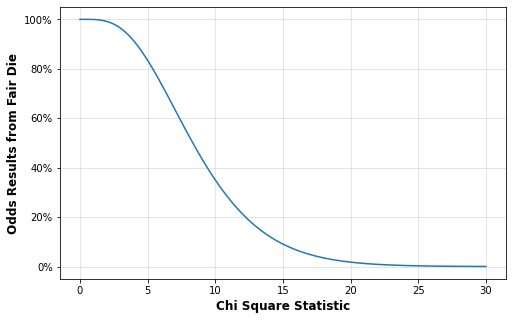

In [30]:
line_x = pd.DataFrame({'size_var': np.linspace(0, 30, 100)})
line_y = 1 - stats.chi2.cdf(line_x, df=9)

fig6, ax6 = plt.subplots(figsize=(8, 5))

ax6.plot(line_x, line_y)

# Chart Formatting
ax6.set_xlabel('Chi Square Statistic', fontweight='bold', fontsize='large')
ax6.set_ylabel('Odds Results from Fair Die', fontweight='bold', fontsize='large')

# Axis Formatting
ax6.grid(alpha=0.4)
ax6.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.0%}'))

fig6.savefig('images/Project 1 - fig6.png')

If we look up our statistic on the x-axis here, we can get the odds that our results came from a fair die on the y-axis. The key thing to note about this distribution is that the relationship isn't linear. There is a significant drop that eventually smoothes out.

## Round Score to Odds from Fair
Since we have this method of determining the odds that our results came from a fair die, let's compare our round score to the odds from the distribtuion.

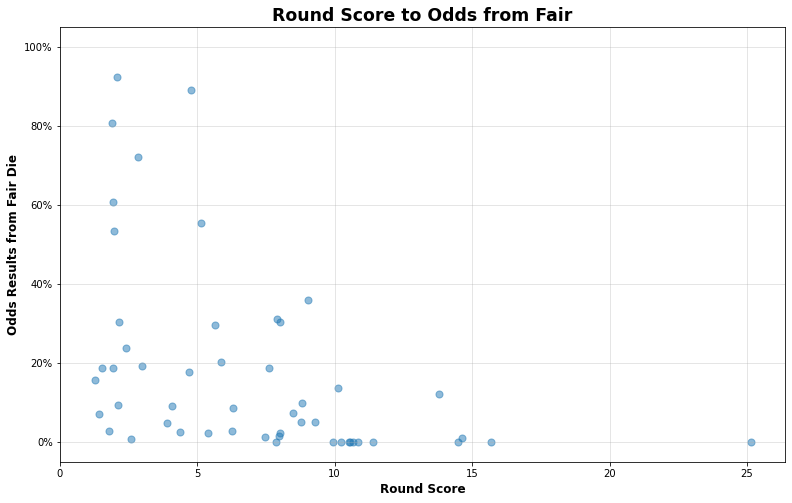

In [31]:
scatter_y = 1 - stats.chi2.cdf(dice_results['chisq_stat'], df=9)

fig7, ax7 = plt.subplots(figsize=(13, 8))
ax7.scatter(dice_results['round_score'], 
            scatter_y,
            alpha=0.5,
            s=50)

# Chart Formatting
ax7.set_title('Round Score to Odds from Fair', fontweight='bold', fontsize='xx-large')
ax7.set_xlabel('Round Score', fontweight='bold', fontsize='large')
ax7.set_ylabel('Odds Results from Fair Die', fontweight='bold', fontsize='large')

# Axis Formatting
ax7.grid(alpha=0.4)

ax7.set_xticks(np.arange(0, 30, 5))
xlim = max(dice_results['round_score']) * 1.05
ax7.set_xlim(0, xlim)

ax7.set_yticks(np.arange(0, 1.2, .2))
ax7.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.0%}'))
ax7.set_ylim(-0.05, 1.05)

fig7.savefig('images/Project 1 - fig7.png')

The above visualization is difficult to interpret, but I will try to clarify what's happening.

Although our predictor between the round score and chi square stat is strong, there is some variation. Because of the sensitivity of the chi square test, those small variations can lead to large swings in the odds that the results we've seen would come from a fair die.

## Using P-Value to Determine Fairness
In experiments that use the Chi Square Test, rather than using the odds as a deciding factor, a threshold is set as a limit for what could possibly be fair and what definitely isn't. This threshold is known as the alpha of the test and is often set at 0.05. This basically means if there is more than a 1/20 chance that the die could be fair, we would conside it "Possibly Fair". What we're looking for with this threshold are dice that definitely not fair.

Using this standard methodology we can split our dice into groups where the results are "Possibly Fair" and "Not Fair".

In [32]:
dice_results['chisq_p'] = 1 - stats.chi2.cdf(dice_results['chisq_stat'], df=9)
dice_results['possibly_fair'] = dice_results['chisq_p'] >= 0.05
dice_results['round_cat'] = pd.cut(dice_results['round_score'], np.arange(0,30, 3))

round_group = dice_results.groupby(['round_cat', 'possibly_fair']).agg(count=('dice_id', 'count')).reset_index()
round_group = round_group.pivot(index='round_cat', columns='possibly_fair', values='count').reset_index()
round_group.columns = ['round_cat', 'not_fair', 'fair']
round_group = round_group[(round_group['fair'] + round_group['not_fair']) > 0]
round_group.head()

,round_cat,not_fair,fair
0,"(0, 3]",2,13
1,"(3, 6]",3,6
2,"(6, 9]",5,7
3,"(9, 12]",7,3
4,"(12, 15]",2,1


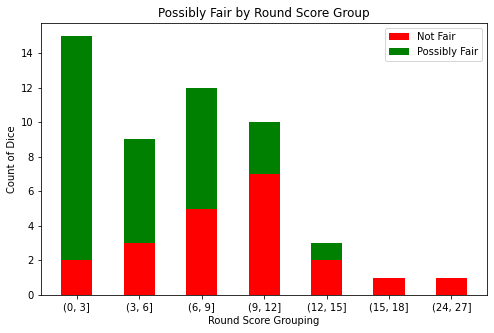

In [33]:
fig8, ax8 = plt.subplots(figsize=(8, 5))

ax8.bar(round_group['round_cat'].astype(str), 
        round_group['not_fair'], 
        width=0.5, 
        color='red',
        label='Not Fair')
ax8.bar(round_group['round_cat'].astype(str), 
        round_group['fair'], 
        bottom=round_group['not_fair'],
        width=0.5, 
        color='green',
        label='Possibly Fair')

ax8.set_title('Possibly Fair by Round Score Group')
ax8.set_ylabel('Count of Dice')
ax8.set_xlabel('Round Score Grouping')
ax8.legend()

fig8.savefig('images/Project 1 - fig8.png')

The above visualization shows the number of possibly fair and not fair die by round score grouping of 3 or more. Let's take another look at this using our scatter plot from earlier.

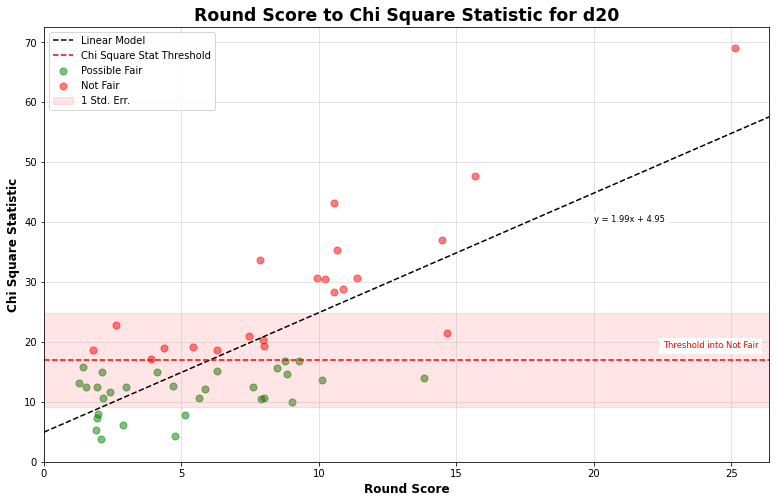

In [34]:
fig9, ax9 = plt.subplots(figsize=(13, 8))
ax9.scatter(dice_results[dice_results['possibly_fair']]['round_score'], 
            dice_results[dice_results['possibly_fair']]['chisq_stat'],
            c='green',
            alpha=0.5,
            s=50, 
            label='Possible Fair')
ax9.scatter(dice_results[~dice_results['possibly_fair']]['round_score'], 
            dice_results[~dice_results['possibly_fair']]['chisq_stat'],
            c='red',
            alpha=0.5,
            s=50, 
            label='Not Fair')

line_x = pd.DataFrame({'round_score': np.linspace(0, 30, 10)})

lr_line = ax9.plot(line_x,
                   lr_res.predict(line_x), 
                   c='black',
                   linestyle='dashed',
                   label='Linear Model')

line_y = np.array([17 for _ in line_x['round_score']])

threshold_line = ax9.plot(line_x['round_score'],
                          line_y, 
                          c='red',
                          linestyle='dashed',
                          label='Chi Square Stat Threshold')

std_err = np.sqrt(lr_res.scale)
conf_int = std_err * 1.96

ax9.fill_between(line_x['round_score'], 
                 line_y - std_err, 
                 line_y + std_err, color='red', alpha=0.1, label='1 Std. Err.')

b, m = lr_res.params
formula = 'y = {m:.2f}x + {b:.2f}'.format(m=m, b=b)
ax9.text(20, 40, formula, c='black', backgroundcolor='white', fontsize='small')

ax9.text(22.5, 19, 'Threshold into Not Fair', c='red', backgroundcolor='white', fontsize='small')

# Chart Formatting
ax9.set_title('Round Score to Chi Square Statistic for d20', fontweight='bold', fontsize='xx-large')
ax9.set_xlabel('Round Score', fontweight='bold', fontsize='large')
ax9.set_ylabel('Chi Square Statistic', fontweight='bold', fontsize='large')

# Axis Formatting
ax9.grid(alpha=0.4)

ax9.set_xticks(np.arange(0, 30, 5))
xlim = max(dice_results['round_score']) * 1.05
ax9.set_xlim(0, xlim)

ax9.set_yticks(np.arange(0, 80, 10))
ylim = max(dice_results['chisq_stat']) * 1.05
ax9.set_ylim(0, ylim)

ax9.legend()

fig9.savefig('images/Project 1 - fig9.png')

The chi square stat that acts as our threshold into not fair with an alpha of 0.05 is 17. Any chi square stat at or above this number is considered not fair. Highlighted is one standard error range for our predictor around 17.

With our linear model between round score and chi square stat, the two intersect at the round score of 6.044.

Dice at or below a round score of 6.044 are more likely to roll fair than those above, however this isn't always the case.

## What is Fair?

Let's take another look at the fair die simulation from earlier.

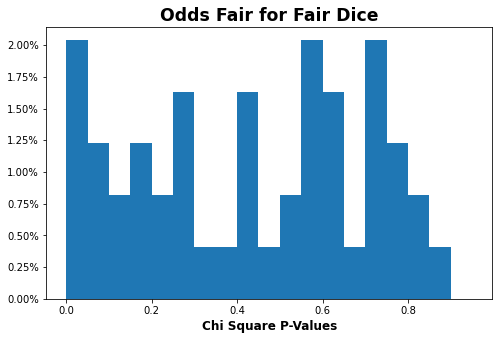

In [35]:
perfect_chisq = []
for dice_id in perfect_df['dice_id'].unique():
    result = perfect_df[perfect_df['dice_id'] == dice_id]
    perfect_chisq.append(stats.chisquare(result['count'], [20 for _ in range(10)]))

chisq_df = pd.DataFrame(perfect_chisq)

fig10, ax10 = plt.subplots(figsize=(8, 5))

ax10.hist(chisq_df['pvalue'], 
         bins=np.arange(0, 1, 0.05), 
         density=True)

ax10.set_title('Odds Fair for Fair Dice', fontweight='bold', fontsize='xx-large')
ax10.set_xlabel('Chi Square P-Values', fontweight='bold', fontsize='large')
ax10.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=100))

fig10.savefig('images/Project 1 - fig10.png')

In [36]:
chisq_df['fair'] = chisq_df['pvalue'] >= 0.05
chisq_df.groupby('fair').agg(count=('pvalue', 'count'))

,count
fair,
False,5
True,46


The above shows the distribution of our chi square tests from our fair dice simulation. We can see that the spread of the calculated odds for these dice is extremely varied. Using the 0.05 threshold, 46 of the 51 dice were properly labeled as fair. However 5 weren't.

This test gives some level of confidence in predicting whether or not a die could be considered fair, but it isn't perfect.

## Analysis Results

There is a strong relationship between the measured round score of a die and the chi square statistic with a defined linear relationship of  
$ y = 1.99x + 4.95 $

Due to the sensitivity of the chi square test, there are wide variations in the odds that a die's results will roll fair compared to the round score.

Setting an alpha of 0.05 for the chi square test shows the threshold for when a die can be considered unfair at a chi square stat of 17. Using the linear relationship we can define the round score that a die becomes less likely to roll fair at 6.044.

However, there are issues with the random nature of the data and the reliability of the chi square test in predicting fairness.

# Analysis 4 - Variation in Size for Different Manufacturers

Finally, let's take a look at the round scores from different manufacturers included in the study. For this analysis we'll remove any brand that had less than 5 dice measured and aren't considered factory seconds.

## Analysis Setup

#### Get Brand Count

In [37]:
brand_count = dice_df.groupby('brand').agg(count=('dice_id', 'count')).reset_index()
dice_df = pd.merge(dice_df, brand_count, on='brand')
dice_df.head()

,dice_id,brand,line,style,weight_g,count
0,1,Chessex (Factory 2nd),Opaque,Opaque Purple with White,6.2,10
1,2,Chessex (Factory 2nd),Opaque,Opaque Yellow with Black,5.9,10
2,3,Chessex (Factory 2nd),Speckled,Speckled Blue/Green with White,6.5,10
3,4,Chessex (Factory 2nd),Speckled,Speckled Light Blue with Black,6.5,10
4,5,Chessex (Factory 2nd),Translucent,Translucent Blue with White,4.9,10


#### Get Round Score

In [38]:
mean_dia = face_pairs_df.groupby('dice_id').agg(mean_dia=('diameter', 'mean')).reset_index()
round_scores = face_pairs_df.groupby('dice_id').agg(std_dev=('diameter', 'std')).reset_index()
round_scores = pd.merge(round_scores, mean_dia, on='dice_id')
round_scores['round_score'] = (round_scores['std_dev'] / round_scores['mean_dia']) * 1000

dice_df = pd.merge(dice_df, round_scores, on='dice_id')
dice_df.head()

,dice_id,brand,line,style,weight_g,count,std_dev,mean_dia,round_score
0,1,Chessex (Factory 2nd),Opaque,Opaque Purple with White,6.2,10,0.196551,19.769,9.942375
1,2,Chessex (Factory 2nd),Opaque,Opaque Yellow with Black,5.9,10,0.208489,19.773,10.544140
2,3,Chessex (Factory 2nd),Speckled,Speckled Blue/Green with White,6.5,10,0.183799,19.816,9.275303
3,4,Chessex (Factory 2nd),Speckled,Speckled Light Blue with Black,6.5,10,0.216500,19.925,10.865743
4,5,Chessex (Factory 2nd),Translucent,Translucent Blue with White,4.9,10,0.273051,18.853,14.483142


#### Filter to appropriate brands

In [39]:
brands_df = dice_df[(dice_df['count'] >= 5) & (dice_df['brand'] != 'Chessex (Factory 2nd)')]
brands_df.head()

,dice_id,brand,line,style,weight_g,count,std_dev,mean_dia,round_score
12,8,Koplow,Opaque,Opaque Blue with White,6.1,8,0.054171,18.927,2.862076
13,9,Koplow,Opaque,Opaque Blue with White,6.0,8,0.097531,19.023,5.126984
14,10,Koplow,Opaque,Opaque White with Black,6.2,8,0.035653,18.884,1.887982
15,11,Koplow,Opaque,Opaque White with Black,6.1,8,0.082738,18.903,4.376970
16,12,Koplow,Opaque,Opaque Green with White,6.2,8,0.102897,19.019,5.410218


## Brand Visualization

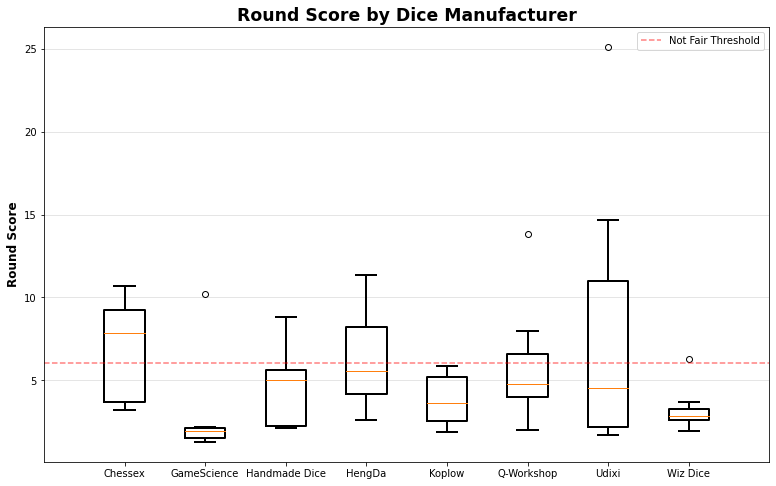

In [40]:
fig11, ax11 = plt.subplots(figsize=(13, 8))

brands = sorted(brands_df['brand'].unique())

for i, brand in enumerate(brands):
    ax11.boxplot(brands_df[brands_df['brand'] == brand]['round_score'],
                 positions=[i + 1], 
                 widths=0.5,
                 boxprops={'linewidth':2}, 
                 capprops={'linewidth':2},
                 whiskerprops={'linewidth':2})

line_x = np.arange(0, 10)
line_y = [6.044 for _ in line_x]

ax11.plot(line_x, line_y, c='red', linestyle='dashed', alpha=0.5, label='Not Fair Threshold')

ax11.set_title('Round Score by Dice Manufacturer', fontweight='bold', fontsize='xx-large')

ax11.grid(axis='y', alpha=0.4)
ax11.set_xticklabels(brands, fontsize='medium')
ax11.set_xlim(0, len(brands) + 1)

ax11.set_ylabel('Round Score', fontweight='bold', fontsize='large')

ax11.legend()

fig11.savefig('images/Project 1 - fig11.png')

The above visualization shows the distribution of the round scores of the dice measured by brand. For reference there is a line at 6.044 of the round score that is assumed to be the threshold into a die rolling unfair from the previous analysis.

We can see there are differences in the dice measured from each manufacturer.

## A Look at Brand Lines

A word of caution about using just brand to make a consideration on if a given die is fair or not.

Manufacturers have different processes depending on the kind of die to be made. The below chart shows the round scores of Chessex lines and how many dice were measured in each.

In [41]:
lines = brands_df.groupby(['brand', 'line'])
lines = lines.agg(average=('round_score', 'mean'), count=('dice_id', 'count')).reset_index()
lines[lines['brand'] == 'Chessex']

,brand,line,average,count
0,Chessex,Gemini,3.373460,2
1,Chessex,Opaque,9.201035,2
2,Chessex,Speckled,10.668192,1
3,Chessex,Translucent,7.981117,1
4,Chessex,Vortex,3.906393,1


While the Opaque, Speckled, and Translucent dice measured are above the threshold, the Gemini and Vortex lines are within range.

It's difficult to tell with the number of dice measured if a given brand can be considered fair or not. To do so would require measuring more dice than made available in this experiment.

## Analysis Results
There is a noticeable difference in the round scores between different manufacturers. However, I caution you to be careful with this difference. There are differences within product lines for single manufacturers. There were not enough dice measured for this study to show this difference or give a complete picture of a manufacturers product line.

I'm including this analysis with this word of caution, because if I did not, someone else would and I worry about potential harmful messaging with this small sample set.